In [1]:
suppressPackageStartupMessages({
    library(dplyr)
    library(stringr)
    library(reshape2)
    library(ggplot2)
    library(ComplexHeatmap)
    library(Seurat)
    library(Signac)
    library(org.Mm.eg.db)
    library(JASPAR2022)
    library(TFBSTools)
    library(motifmatchr)
    library(chromVAR)
    library(Mfuzz)
})

Warning message:
“no function found corresponding to methods exports from ‘BSgenome’ for: ‘releaseName’”
Warning message:
“package ‘e1071’ was built under R version 4.1.3”
Warning message:
“no DISPLAY variable so Tk is not available”


In [2]:
col_nor <- function(df){
    center <- sweep(df, 1, apply(df, 1, min),'-')
    R <- apply(df, 1, max) - apply(df, 1, min)
    df <- sweep(center, 1, R, "/")
    return(df)
}

In [3]:
col_nor2 <- function(df){
    center <- sweep(df, 2, apply(df, 2, min),'-')
    R <- apply(df, 2, max) - apply(df, 2, min)
    df <- sweep(center, 2, R, "/")
    return(df)
}

#### Files
|Name|Description|
|:-|:-|
|share.rds|preprocessed file (It is the Seurat format and can be generated follow the official tutorial of Seurat.)|
|pseudotime_palantir.csv|pseudotime calculated by Palantir|
|cross_attention.csv|cross-attention generated by Attune|
|tac_predict.tsv|Prediction matrix generated from residual.ipynb. It is generated from residual.ipynb.|
|tac_measure.tsv|Measurement matrix generated from residual.ipynb. It is generated from residual.ipynb.|

#### preprocess

In [4]:
share <- readRDS('share.rds')

In [5]:
use_ct <- c('TAC-1','TAC-2','IRS','Hair Shaft-Cuticle/Cortex','Medulla')

In [6]:
share <- subset(x = share, idents = use_ct)

In [7]:
ptime <- read.csv('data/pseudotime_palantir.csv', header=F)
colnames(ptime) <- c('cell', 'time')
rownames(ptime) <- ptime[,1]

In [8]:
common_cells <- intersect(rownames(share@meta.data), rownames(ptime))

In [9]:
ptime <- ptime[common_cells,]
ptime <- ptime %>% arrange(time)
common_cells <- rownames(ptime)

In [10]:
col_anno <- ptime[,c('time'),drop=F]
col_anno$cell_type <- share@meta.data[common_cells, 'cell_type']

In [11]:
## generate atac_allgene_data.mtx
library(Matrix)
writeMM(t(share$ATAC@data), file='atac_data.mtx')
write.table(rownames(t(share$ATAC@data)),file="atac_cell.txt", sep="\t", row.name=F, col.name=F, quote=F)
write.table(colnames(t(share$ATAC@data)),file="atac_peak.txt", sep="\t", row.name=F, col.name=F, quote=F)


Attaching package: ‘Matrix’


The following object is masked from ‘package:TFBSTools’:

    Matrix


The following object is masked from ‘package:S4Vectors’:

    expand




NULL

##### Filter Gli3 peaks with attention

In [12]:
## 可以用attention与gene body交集去掉部分peak
attention = read.csv('../result/cross_attention/cross_attention.csv', header=T)

In [13]:
attention$variable <- str_replace(attention$variable,':','-')
gplink_f <- attention %>% arrange(desc(value)) %>% filter(value > quantile(value, .95))
names(gplink_f) <- c('gene', 'peak', 'weight')
gli3_peak <- gplink_f %>% subset(gene=='Gli3') %>% pull(peak)

In [14]:
gli3_peak %>% unique %>% length

[1] 49

In [18]:
write.table(gplink_f %>% subset(gene=='Gli3'), file='Gli3.tsv', sep="\t", row.name=F)

#### load Motif

In [14]:
DefaultAssay(share) <- "ATAC"
pwm_set <- getMatrixSet(x = JASPAR2022, opts = list(collection = "CORE", tax_group = 'vertebrates', all_versions = FALSE))
motif.matrix <- CreateMotifMatrix(features = granges(share), pwm = pwm_set, genome = 'mm10', score=T, use.counts = FALSE)
motif.object <- CreateMotifObject(data = motif.matrix, pwm = pwm_set)
share <- SetAssayData(share, assay = 'ATAC', slot = 'motifs', new.data = motif.object)
share <- RegionStats(share, genome = BSgenome.Mmusculus.UCSC.mm10)


Attaching package: ‘Biostrings’


The following objects are masked from ‘package:Hmisc’:

    mask, translate


The following object is masked from ‘package:grid’:

    pattern


The following object is masked from ‘package:base’:

    strsplit




##### Generate background

In [15]:
chrom_z <- function (object, genome, motif.matrix = NULL, verbose = TRUE, ...) {
    if (!requireNamespace("chromVAR", quietly = TRUE)) {
        stop("Please install chromVAR. https://greenleaflab.github.io/chromVAR/")
    }
    if (!requireNamespace("SummarizedExperiment", quietly = TRUE)) {
        stop("Please install SummarizedExperiment")
    }
    motif.matrix <- GetMotifData(object = object, slot = "data")
    peak.matrix <- GetAssayData(object = object, slot = "counts")
    if (!(all(peak.matrix@x == floor(peak.matrix@x)))) {
        warning("Count matrix contains non-integer values.\n            ChromVAR should only be run on integer counts.")
    }
    idx.keep <- rowSums(x = peak.matrix) > 0
    peak.matrix <- peak.matrix[idx.keep, , drop = FALSE]
    motif.matrix <- motif.matrix[idx.keep, , drop = FALSE]
    peak.ranges <- granges(x = object)
    peak.ranges <- peak.ranges[idx.keep]
    chromvar.obj <- SummarizedExperiment::SummarizedExperiment(assays = list(counts = peak.matrix), 
        rowRanges = peak.ranges)
    if (verbose) {
        message("Computing GC bias per region")
    }
    chromvar.obj <- chromVAR::addGCBias(object = chromvar.obj, 
        genome = genome)
    if (verbose) {
        message("Selecting background regions")
    }
    bg <- chromVAR::getBackgroundPeaks(object = chromvar.obj, 
        ...)
    if (verbose) {
        message("Computing deviations from background")
    }
    return(bg)
}

In [17]:
bg <- chrom_z(
  object = share,
  genome = BSgenome.Mmusculus.UCSC.mm10
)
all_peak <- rownames(share$ATAC@meta.features)[rowSums(x = share$ATAC@counts) > 0]
rownames(bg) <- all_peak

In [18]:
motif_data <- share$ATAC@motifs@data

#### cFuzz of peaks

In [19]:
## We remove 'IRS' cells, because it is another differentiation branch of TAC. 
use_ct <- c('TAC-1', 'TAC-2', 'Medulla', 'Hair Shaft-Cuticle/Cortex')
share_tmp <- subset(x = share, idents = use_ct)

In [20]:
## binning along pseudotime
common_cells <- intersect(rownames(share_tmp@meta.data), rownames(ptime))
ptime <- ptime[common_cells,]
ptime <- ptime %>% arrange(time)
common_cells <- rownames(ptime)

In [21]:
gli3_count <- as.matrix(share_tmp$ATAC@data[gli3_peak, common_cells])

In [22]:
bin <- function(df){
    bnum <- 10
    len <- ceiling(dim(df)[2]/bnum)
    r <- c()
    ct <- c()
    for(i in 0:(bnum-1)){
        start = i*len + 1
        end = ifelse((i+1)*len > dim(df)[2], dim(df)[2], (i+1)*len)
        ct_tmp <- data.frame(time = rep(paste0("t", i+1), end-start+1), cells = colnames(df[,start:end]))
        ct <- rbind(ct, ct_tmp)
        result <- apply(df[,start:end], 1, mean)
        result <- as.data.frame(result)
        colnames(result) <- paste0("t", i+1)
        if(length(r) == 0){
            r <- result
        }else{
            r <- cbind(r, result)
        }
    }
    list(r, ct)
}

In [23]:
gli3_count <- bin(gli3_count)
ptime[gli3_count[[2]]$cells, 'cbin'] <- gli3_count[[2]]$time
gli3_count <- gli3_count[[1]]

In [24]:
dat <- new('ExpressionSet', exprs=as.matrix(gli3_count))
dat <- standardise(dat)
m1 <- mestimate(dat)

[1] 2.891015e+00 1.539071e+00 8.450417e-03 1.253485e-03 2.194410e-04
 [6] 1.449144e-03 5.584922e-05 1.575377e-04 1.760047e-01 2.806635e-01
[11] 3.248618e-03 9.039562e-02 9.959224e-01 9.969113e-01 1.494046e+00
[16] 1.615517e+00 1.050516e+00 1.443477e+00 1.404085e+00

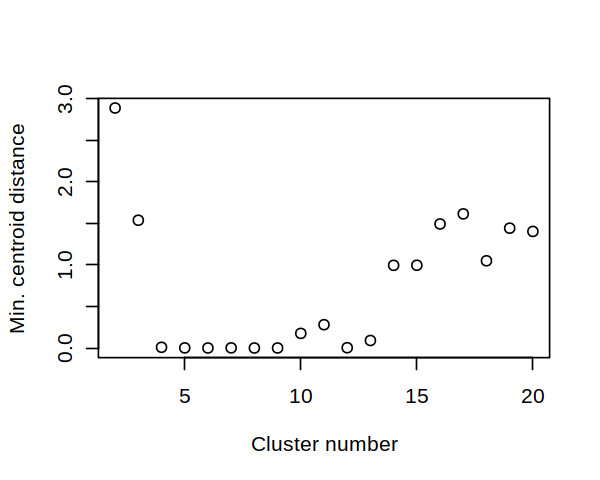

In [25]:
options(repr.plot.width=5, repr.plot.height=4)
Dmin(dat, m=m1, crange=seq(2,20,1), repeats=3, visu=TRUE)

In [26]:
set.seed(321)
cl <- mfuzz(dat, c=4, m1)

Warning message in if (colo == "fancy") {:
“the condition has length > 1 and only the first element will be used”


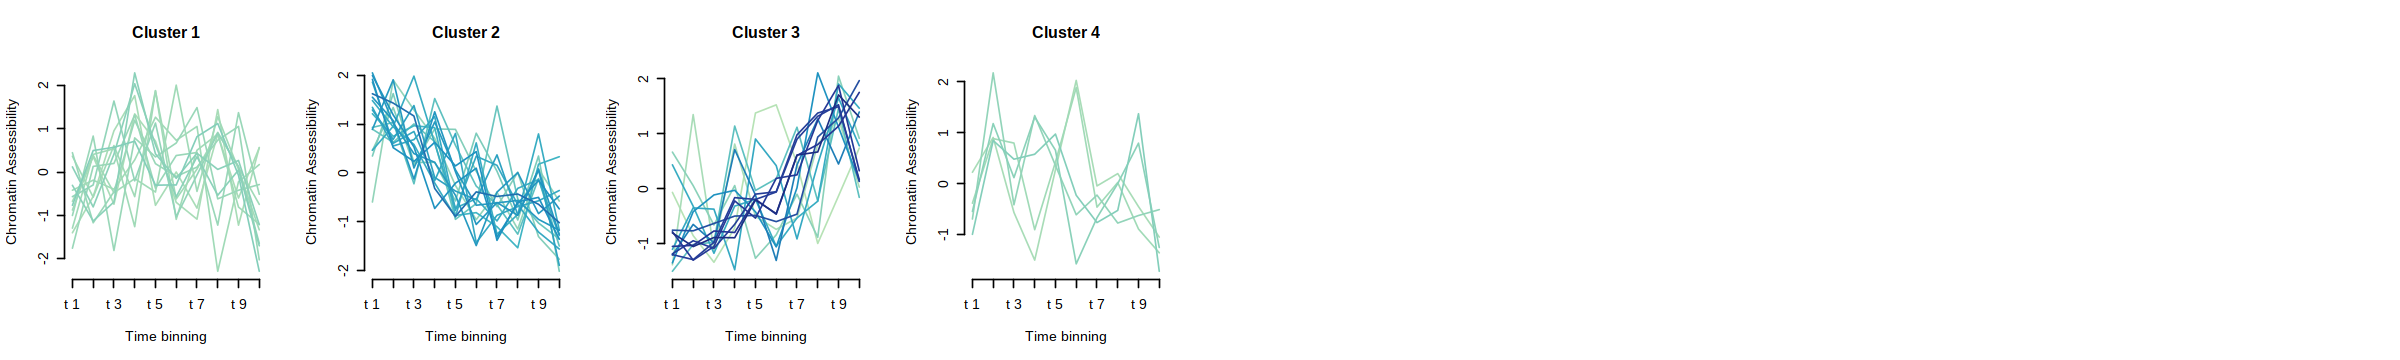

In [29]:
options(repr.plot.width=20, repr.plot.height=3)
colos = colorRampPalette(RColorBrewer::brewer.pal(9,"YlGnBu"))(80)
mfuzz.plot2(dat, cl=cl, mfrow=c(1,8), colo = colos, time.label=paste(rep('t',10),seq(1,10)), x11=F, ylab='Chromatin Assessibility', xlab='Time binning')

In [30]:
cc <- as.data.frame(cbind(cl$cluster, cl$membership))
cc$peak <- rownames(cc)
colnames(cc) <- c('cluster', 'c1', 'c2', 'c3', 'c4', 'peak')

cc <- cc %>% subset(cluster %in% c(2,3))
cc_select <- melt(cc[,2:6], id='peak') %>% group_by(variable) %>% subset(variable %in% c('c2','c3'))

In [31]:
cc_select %>% head

peak,variable,value
<chr>,<fct>,<dbl>
chr13-15741721-15742021,c2,0.6312239
chr13-15513178-15513478,c2,0.4204041
chr13-15710707-15711007,c2,0.3769111
chr13-15463049-15463349,c2,0.3835273
chr13-15588152-15588452,c2,0.3494468
chr13-15468442-15468742,c2,0.1231458


#### gene-peak correlation

##### correlation

In [33]:
use_ct <- c('TAC-1','TAC-2','Hair Shaft-Cuticle/Cortex','Medulla')
share_tmp <- subset(x = share, idents = use_ct)

In [37]:
rna <- as.matrix(share_tmp$RNA@data)
atac <- as.matrix(share_tmp$ATAC@data[gli3_peak,])
activity <- as.matrix(share_tmp$activity@data)

rna <- rna[apply(rna, 1, sd) != 0, ]

In [38]:
final_r <- c()
for(i in gli3_peak){
    result <- sapply(rownames(rna), function(x){cor(atac[i,], rna[x,], method="spearman")})
    result <- as.data.frame(t(result))
    result$peak <- i
    final_r <- rbind(final_r, result)
}

In [39]:
final_l <- melt(final_r, id='peak')

##### filer peaks
(1) high membership value; (2) plot

In [41]:
cc_select <- cc_select %>% subset(value > 0.5)

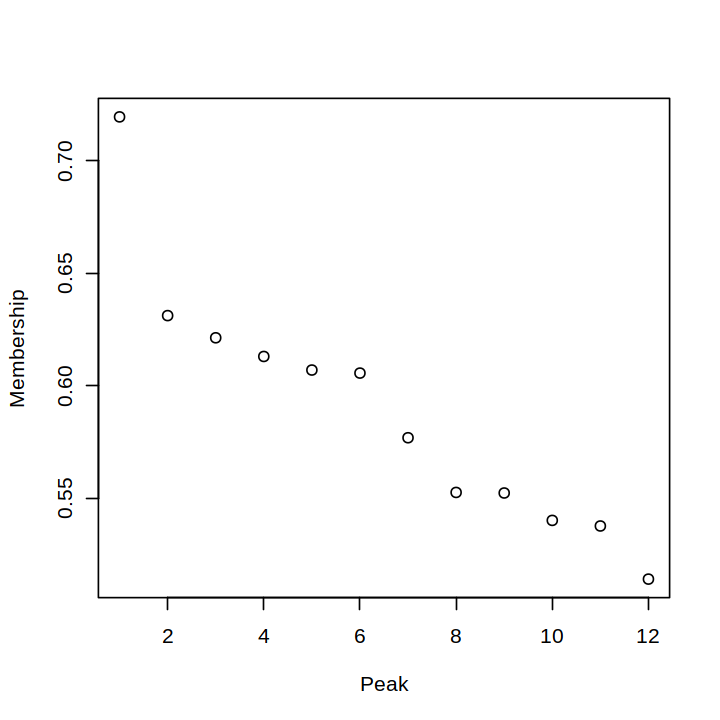

In [82]:
## We keep 6 peaks in cluster 2 for subsequent analysis. 
options(repr.plot.width=6, repr.plot.height=6)
plot(x=1:nrow(cc_select %>% subset(variable == 'c2')), y=cc_select %>% subset(variable == 'c2') %>% arrange(desc(value)) %>% pull(value), xlab='Peak', ylab='Membership')

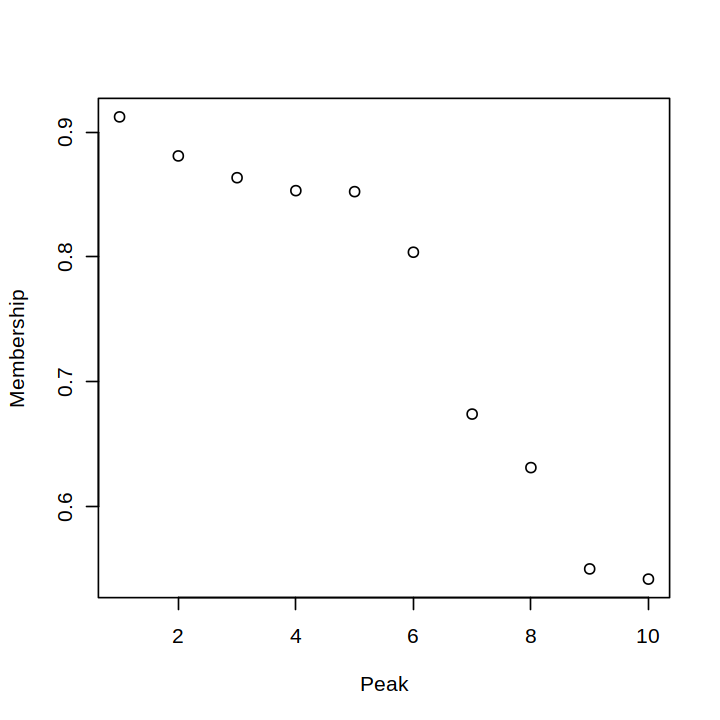

In [83]:
## ## We keep 5-6 peaks in cluster 2 for subsequent analysis.
options(repr.plot.width=6, repr.plot.height=6)
plot(x=1:nrow(cc_select %>% subset(variable == 'c3')), y=cc_select %>% subset(variable == 'c3') %>% arrange(desc(value)) %>% pull(value), xlab='Peak', ylab='Membership')

In [44]:
## select top genes associated with all peaks in cluster 2
count_down <- c()
for(i in 6){
    down_peak <- cc_select %>% subset(variable == 'c2') %>% top_n(i, value) %>% pull(peak)
    fm <- final_l %>% subset(peak %in% down_peak) %>% group_by(variable) %>% summarise(mean=mean(value)) %>% arrange(desc(mean)) %>% as.data.frame
    count_down <- rbind(count_down, fm[1:5,])
}

In [45]:
sort(table(as.vector(count_down$variable)), decreasing=T)


    Eda    Nfib    Ntn1    Sox5 Tspan18 
      1       1       1       1       1 

In [46]:
## select top genes associated with all peaks in cluster 3
count_up <- c()
for(i in 5:6){
    up_peak <- cc_select %>% subset(variable == 'c3') %>% top_n(i, value) %>% pull(peak)
    fm <- final_l %>% subset(peak %in% up_peak) %>% group_by(variable) %>% summarise(mean=mean(value)) %>% arrange(desc(mean)) %>% as.data.frame
    count_up <- rbind(count_up, fm[1:5,])
}

In [47]:
sort(table(as.vector(count_up$variable)), decreasing=T)


Bmper Foxp1  Lef1 Prr5l Dach1  Psd3 
    2     2     2     2     1     1 

##### Statistical significance
Spearman correlation coefficient between background peaks and the gene

In [50]:
c2_peaks <- (cc_select %>% subset(variable == 'c2') %>% arrange(desc(value)) %>% pull(peak))[1:6]
c3_peaks <- (cc_select %>% subset(variable == 'c3') %>% arrange(desc(value)) %>% pull(peak))[1:6]
c_all_bg <- t(apply(bg[union(c2_peaks, c3_peaks),], 1, function(x){all_peak[x]}))

In [51]:
atac <- as.matrix(share_tmp$ATAC@data[as.vector(c(as.vector(c_all_bg), union(c2_peaks, c3_peaks)) %>% unique),])

In [52]:
options(digits = 3)

In [53]:
tmp_atac <- c2_peaks
bg_peak <- as.vector(c_all_bg[c2_peaks,]) %>% unique
tmp_g = c('Eda','Ntn1','Nfib','Sox5','Tspan18')
sapply(tmp_g, function(gg){
    tmp_gene <- rna[gg,]
    obs <- sapply(tmp_atac,function(pp){cor(atac[pp,], tmp_gene, method="spearman")})
    pop <- sapply(bg_peak,function(pp){cor(atac[pp,], tmp_gene, method="spearman")})
    format(wilcox.test(obs, pop)$p.value, scientific = T)
})

Eda       Ntn1       Nfib       Sox5    Tspan18 
"6.01e-04" "4.38e-04"  "2.2e-04" "6.67e-04" "4.79e-04"

In [54]:
tmp_atac <- c3_peaks
bg_peak <- as.vector(c_all_bg[c3_peaks,]) %>% unique
tmp_g = c('Bmper','Lef1','Prr5l','Dach1','Foxp1')
sapply(tmp_g, function(gg){
    tmp_gene <- rna[gg,]
    obs <- sapply(tmp_atac,function(pp){cor(atac[pp,], tmp_gene, method="spearman")})
    pop <- sapply(bg_peak,function(pp){cor(atac[pp,], tmp_gene, method="spearman")})
    format(wilcox.test(obs, pop)$p.value, scientific = T)
})

Bmper       Lef1      Prr5l      Dach1      Foxp1 
"1.64e-04" "1.52e-04" "1.43e-04" "2.85e-04" "4.72e-05"

#### Visualization

In [55]:
gpred <- read.csv('tac_predict.tsv', sep="\t")
gtruth <- read.csv('tac_measure.tsv', sep="\t")
rownames(gpred) <- gpred$X
gpred <- gpred[,-1]
rownames(gtruth) <- gtruth$X
gtruth <- gtruth[,-1]

In [57]:
gli3_pt <- cbind(gpred[,'Gli3',drop=F], gtruth[,'Gli3',drop=F])
colnames(gli3_pt) <- c('Prediction', 'Measurement')
gli3_pt <- col_nor2(gli3_pt)
gli3_pt$Residual <- gli3_pt$Prediction - gli3_pt$Measurement
gli3_pt <- t(gli3_pt)

In [58]:
col_anno <- ptime %>% group_by(cbin) %>% summarise(mt = mean(time)) %>% as.data.frame

In [59]:
row.names(col_anno) <- col_anno$cbin

In [60]:
col_anno[paste0('t',seq(1,10)),] -> col_anno

In [61]:
col_anno <- col_anno[,c('mt'),drop=F]

In [62]:
colnames(col_anno) <- 'Time'

In [63]:
genes1 <- c('Eda','Ntn1','Nfib','Sox5','Tspan18','Bmper','Lef1','Prr5l','Dach1','Foxp1','Gli3')
peaks1 <- union(c2_peaks, c3_peaks)
act1 <- c('Gli3')

In [64]:
bin <- function(){
    r <- c()
    for(i in (ptime$cbin %>% unique)){
        aa <- as.data.frame(apply(rna[genes1,ptime %>% subset(cbin==i) %>% pull(cell)], 1, mean))
        bb <- as.data.frame(apply(atac[peaks1,ptime %>% subset(cbin==i) %>% pull(cell)], 1, mean))
        colnames(aa) <- i
        colnames(bb) <- i
        result <- rbind(aa,bb)
        if(length(r) == 0){
            r <- result
        }else{
            r <- cbind(r, result)
        }
    }
    r
}

In [65]:
up_down <- bin()

In [66]:
bin2 <- function(){
    r <- c()
    pptime <- ptime[intersect(rownames(ptime), rownames(gtruth)),]
    for(i in (pptime$cbin %>% unique)){
        result <- as.data.frame(apply(gli3_pt[, pptime %>% subset(cbin==i) %>% pull(cell)], 1, mean))
        colnames(result) <- i
        if(length(r) == 0){
            r <- result
        }else{
            r <- cbind(r, result)
        }
    }
    r
}

In [67]:
gli3_var <- bin2()

In [68]:
p1 <- pheatmap(as.matrix(col_nor(up_down[c('Eda','Ntn1','Nfib','Sox5','Tspan18'),])), color = colorRampPalette(c("white", "#277BC0"))(50),   ##  annotation_col = col_anno,show_colnames = FALSE, 
    clustering_method='ward.D2', use_raster=F, cluster_cols = F, show_colnames = FALSE, 
    legend = T, border_color='white', border_gp = gpar(col = "black"), 
    cellwidth = unit(5, 'mm'), row_title = "Deactivating Genes", row_title_rot = 0, column_title = "Regulation Shifting",
    heatmap_legend_param = list(title = "Normalized\nData\n", at = c(0, 0.5, 1), labels = c("", "", "")),
)

In [69]:
p2 <- pheatmap(as.matrix(col_nor(up_down[(cc_select %>% subset(variable == 'c2') %>% arrange(desc(value)) %>% pull(peak))[1:6],])), color = colorRampPalette(c("white", "#277BC0"))(50),   ##  annotation_col = col_anno,show_colnames = FALSE, 
    use_raster=F, cluster_cols = F, cluster_rows = F, show_colnames = FALSE, 
    legend = FALSE, border_color='white', border_gp = gpar(col = "black"), 
    cellwidth = unit(5, 'mm'), row_title = "Deactivating Peaks\n\n(Cluster 2)", row_title_rot = 0
)

In [70]:
p3 <- pheatmap(as.matrix(col_nor(up_down[c('Bmper','Lef1','Prr5l','Dach1','Foxp1'),])), color = colorRampPalette(c("white", "#FF4A4A"))(50),   ##  annotation_col = col_anno,show_colnames = FALSE, 
    clustering_method='ward.D2', use_raster=F, cluster_cols = F, show_colnames = FALSE, 
    legend = T, border_color='white', border_gp = gpar(col = "black"),
    cellwidth = unit(5, 'mm'), row_title = "Activating Genes", row_title_rot = 0,
    heatmap_legend_param = list(title = "", at = c(0, 0.5, 1), labels = c("", "", "")),
)

In [71]:
p4 <- pheatmap(as.matrix(col_nor(up_down[(cc_select %>% subset(variable == 'c3') %>% arrange(desc(value)) %>% pull(peak))[1:6],])), color = colorRampPalette(c("white", "#FF4A4A"))(50),   ##  annotation_col = col_anno,show_colnames = FALSE, 
    use_raster=F, cluster_cols = F, cluster_rows = F, # show_colnames = FALSE, 
    legend = F, row_title_rot = 0, border_color='white', border_gp = gpar(col = "black"), angle_col='45',
    cellwidth = unit(5, 'mm'), row_title = "Activating Peaks\n\n(Cluster 3)"
)

In [72]:
p5 <- pheatmap(as.matrix(col_nor(gli3_var)), color = colorRampPalette(c("white", "#333333"))(50),   ##  annotation_col = col_anno,show_colnames = FALSE, 
    use_raster=F, cluster_cols = F, cluster_rows = F, # show_colnames = FALSE, 
    legend = T, row_title_rot = 0, border_color='white', border_gp = gpar(col = "black"), angle_col='45',
    cellwidth = unit(5, 'mm'), row_title = "Gli3",
    heatmap_legend_param = list(title = "", at = c(0, 0.5, 1), labels = c("0", "0.5", "1")),
)

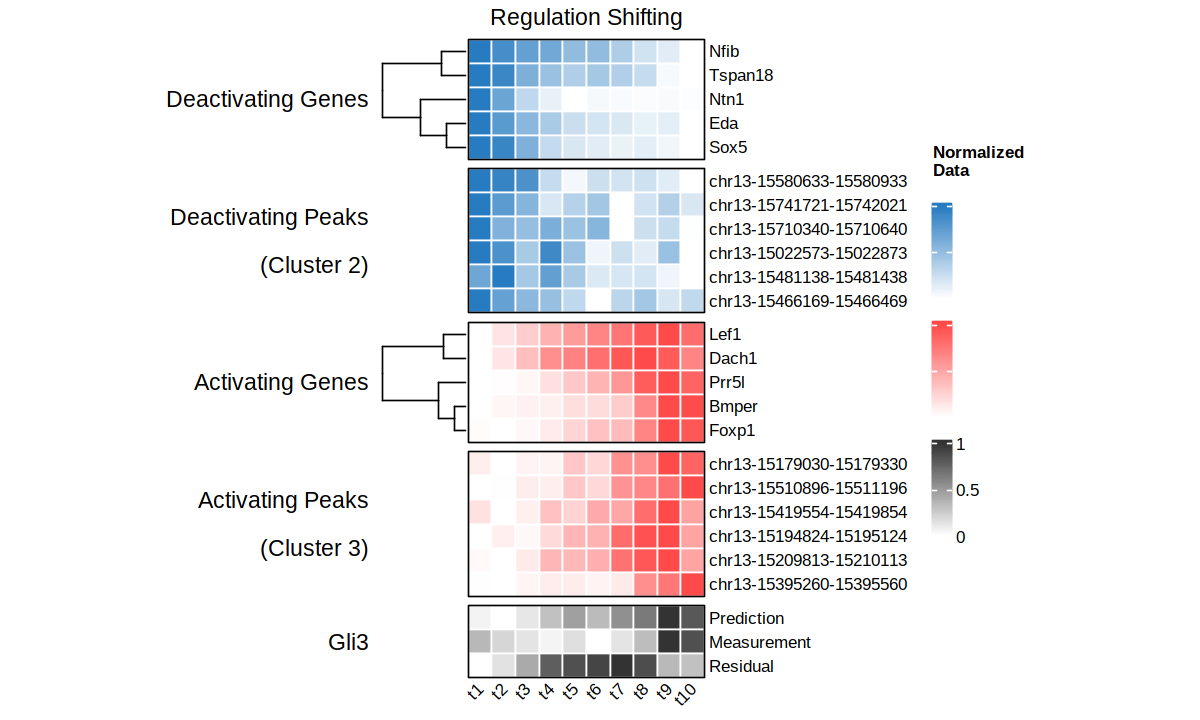

In [73]:
options(repr.plot.width=10, repr.plot.height=6)
p1 %v% p2 %v% p3 %v% p4 %v% p5

##### gene-peak correlation

In [74]:
all_gp <- dcast(final_l %>% 
      subset(
          (variable %in% c('Eda','Ntn1','Nfib','Sox5','Tspan18','Bmper','Lef1','Prr5l','Dach1','Foxp1')) & 
          (peak %in% (cc_select %>% subset(variable %in% c('c2','c3')) %>% arrange(desc(value)) %>% pull(peak)))
      ), peak~variable)

rownames(all_gp) <- all_gp[,1]
all_gp <- all_gp[,-1]

In [75]:
all_gp <- all_gp[
    c((cc_select %>% subset(variable == 'c2') %>% arrange(desc(value)) %>% pull(peak))[1:6], (cc_select %>% subset(variable == 'c3') %>% arrange(desc(value)) %>% pull(peak))[1:6]), 
    c('Eda','Ntn1','Nfib','Sox5','Tspan18','Bmper','Lef1','Prr5l','Dach1','Foxp1')
]

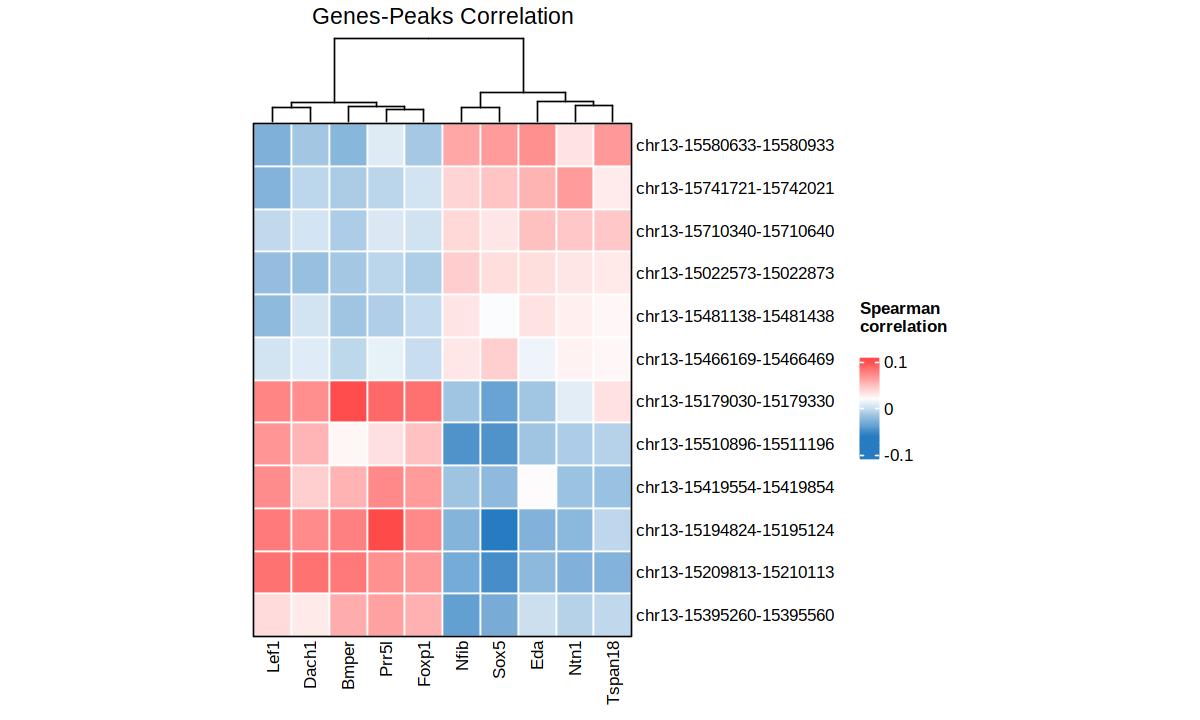

In [76]:
options(repr.plot.width=10, repr.plot.height=6)
pheatmap(as.matrix(all_gp), color = colorRampPalette(c("#277BC0", "white", "#FF4A4A"))(50),   ##  annotation_col = col_anno,show_colnames = FALSE, 
    use_raster=F, cluster_rows = F, # show_colnames = FALSE, cluster_cols = F, 
    legend = T, row_title_rot = 0, border_color='white', border_gp = gpar(col = "black"), #angle_col='45',
    cellwidth = unit(8, 'mm'), column_title = "Genes-Peaks Correlation", 
    heatmap_legend_param = list(title = "Spearman\ncorrelation\n", at = c(-0.1, 0, 0.1), labels = c("-0.1", "0", "0.1")),
)

##### Composition of cell types

In [77]:
ptime$cell_type <- share@meta.data[rownames(ptime), 'cell_type']

In [78]:
gg <- ptime %>% group_by(cbin,cell_type) %>% summarise(n=n()) %>% as.data.frame

`summarise()` has grouped output by 'cbin'. You can override using the
`.groups` argument.


In [79]:
gg$cell_type <- factor(gg$cell_type, levels=c('TAC-1','TAC-2','Medulla','Hair Shaft-Cuticle/Cortex'))

In [80]:
gg$cbin <- factor(gg$cbin, levels=paste0('t',seq(1,10)))

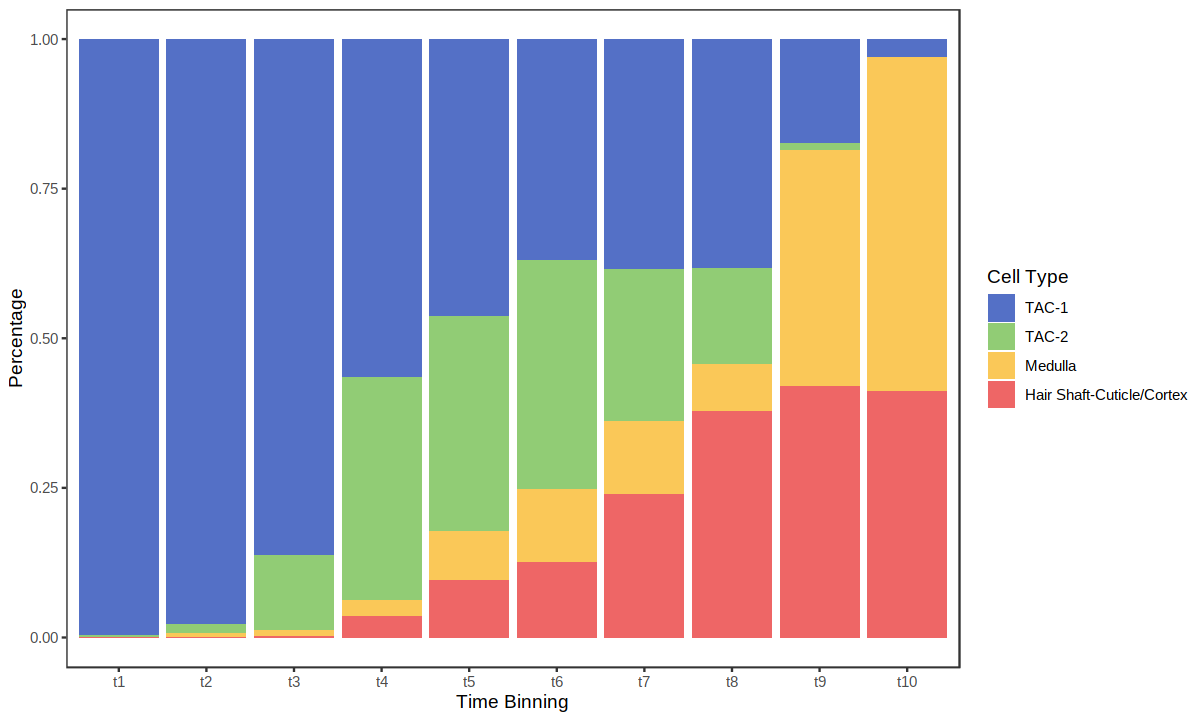

In [81]:
ggplot(gg,aes(x=cbin, y=n, fill=cell_type)) + 
    geom_bar(stat="identity", position="fill") + xlab('Time Binning') + ylab('Percentage') + theme_bw() + 
    #theme(axis.text.y=element_blank(), axis.ticks.y=element_blank()) + 
    labs(fill="Cell Type") + #ggtitle ("Cell type composition") + 
    theme(panel.grid.major.x = element_blank(), panel.grid.minor.x = element_blank(), panel.grid.major.y = element_blank(), panel.grid.minor.y = element_blank()) + 
    scale_fill_manual(values=c("#5470c6","#91cc75","#fac858","#ee6666"))